In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pydub import AudioSegment
from scipy.fft import rfft, rfftfreq, irfft

In [2]:
plt.rcParams["figure.figsize"] = (20,5)

In [3]:
# Парсим pydub AudioSegment в numpy массив уровней квантизации. Массив может состоять из 1 стобца(канала) при моно звуке и из 2 столбцов(каналов) при стерео
def pydub_to_np(audio: AudioSegment) -> np.ndarray:
    return np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels))

In [4]:
# Трансформирует стерео звук в моно, вычисляя среднее между левым и правым каналом. dtype = int чтобы округлить до нижнего уровня
def stereo_to_mono(stereo: np.ndarray) -> np.ndarray:
    return np.mean(stereo, axis = 1, dtype=int)

In [5]:
# Нормализирует массив уровней квантизации к [-1, 1] интервалам
def normalize_mono(mono_sound: np.ndarray, sample_width: int) -> np.ndarray:
    bitrate = 1 << (8 * sample_width - 1)
    return mono_sound / bitrate

In [6]:
# Денормализирует массив уровней квантизации обратно к исходному интервалу
def denormalize_mono(mono_sound: np.ndarray, sample_width: int) -> np.ndarray:
    bitrate = 1 << (8 * sample_width - 1)
    res = mono_sound * bitrate
    return res.astype('int')

In [7]:
amplitude = 1
discr = 1024

func = lambda x: amplitude * np.sin(2 * np.pi * x *  2) \
                 + 0.5 * amplitude * np.sin(2 * np.pi * x * 3) \
                 + 0.1 * amplitude * np.sin(2 * np.pi * x * 7)

In [8]:
X = np.arange(0, 1, 1 / discr)
Y = func(X)

Text(0, 0.5, 'Нормализованная амплитуда')

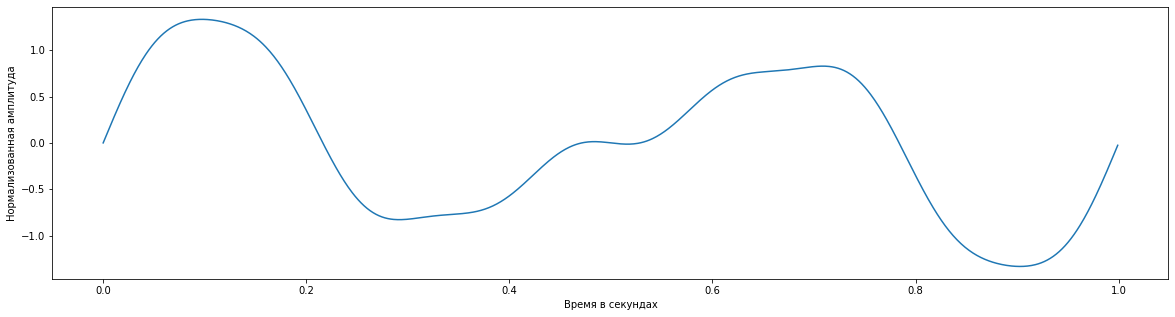

In [9]:
plt.plot(X, Y)
plt.xlabel('Время в секундах')
plt.ylabel('Нормализованная амплитуда')

In [10]:
fftY = rfft(Y)
x_freq = rfftfreq(len(Y), d = 1 / discr)
y_freq = (2 / len(Y)) * np.abs(fftY)

Text(0, 0.5, 'Амплитуда')

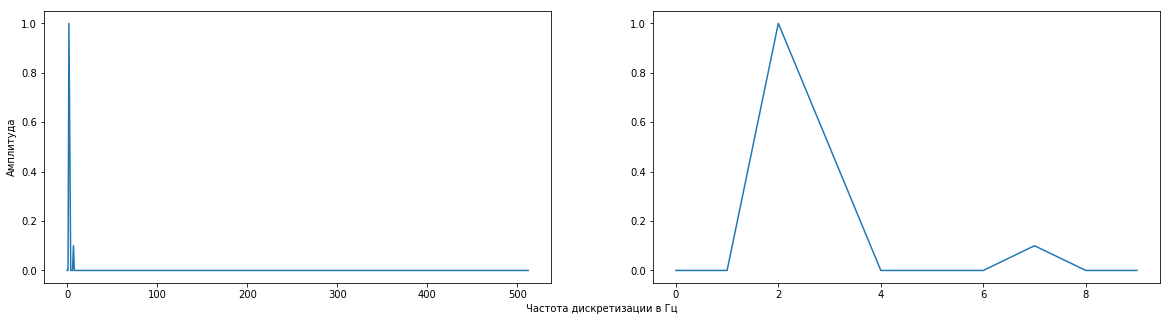

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x_freq, y_freq)
ax2.plot(x_freq[:10], y_freq[:10])

fig.add_subplot(111, frameon= False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel("Частота дискретизации в Гц")
plt.ylabel("Амплитуда")

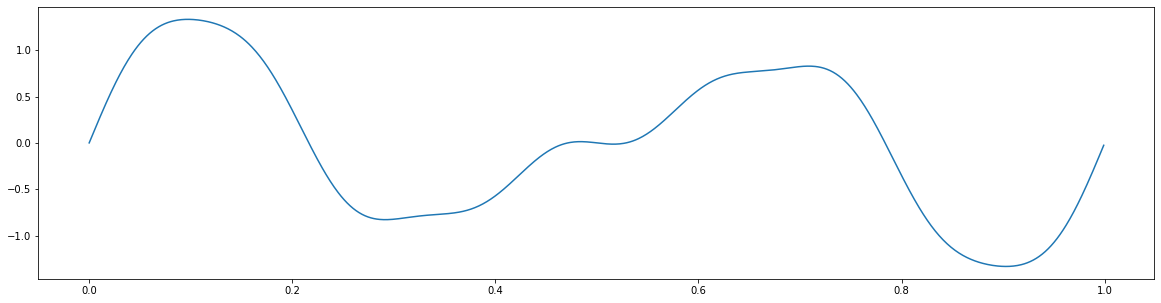

In [12]:
y_from_fft = irfft(fftY)
plt.plot(X, y_from_fft)

In [13]:
f1 = lambda x: amplitude * np.sin(2 * np.pi * x *  2)
f2 = lambda x: amplitude * 0.5 * np.sin(2 * np.pi * x *  3)
f3 = lambda x: amplitude * 0.3 * np.sin(2 * np.pi * x *  10)
discr = 1024

In [14]:
X = np.arange(0, 3, 1 / discr)

In [15]:
Y = np.asarray([f1(x) for x in X[:1024 * 1]] + \
    [f2(x) for x in X[1024 * 1:1024 * 2]] + \
    [f3(x) for x in X[1024 * 2:1024 * 3]])

Text(0, 0.5, 'Нормализованная амплитуда')

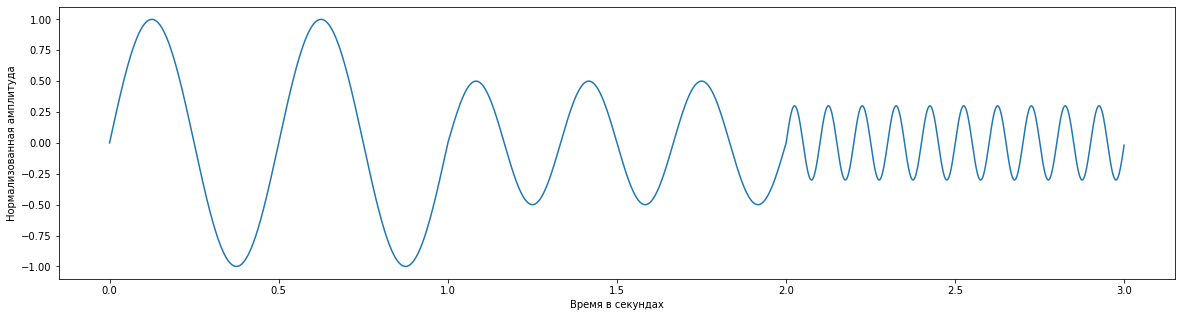

In [16]:
plt.plot(X, Y)
plt.xlabel('Время в секундах')
plt.ylabel('Нормализованная амплитуда')

In [17]:
# Генератор, возвращает чанк из n элементов
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [18]:
sample_size = 1024

In [19]:
def plot_example(X, Y, sample_size = 1024):
    for chunkX, chunkY in zip(chunks(X, sample_size), chunks(Y, sample_size)):
        plt.plot(chunkX, chunkY)
        plt.xlabel('Время в секундах')
        plt.ylabel('Нормализованная амплитуда')

    for chunkY in chunks(Y, sample_size):
        fftY = rfft(chunkY)
        x_freq = rfftfreq(len(chunkY), d = 1 / discr)
        y_freq = (2 / len(chunkY)) * np.abs(fftY)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(x_freq, y_freq)
        ax2.plot(x_freq[:20], y_freq[:20])

        fig.add_subplot(111, frameon= False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

        plt.xlabel("Частота дискретизации в Гц")
        plt.ylabel("Амплитуда")

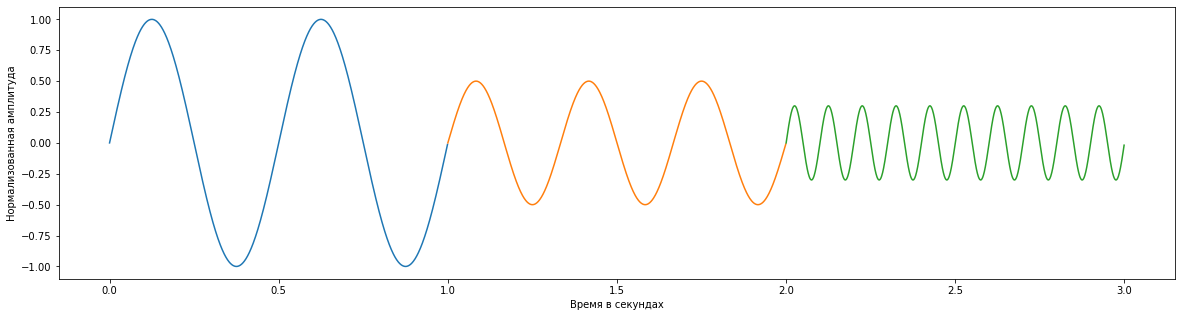

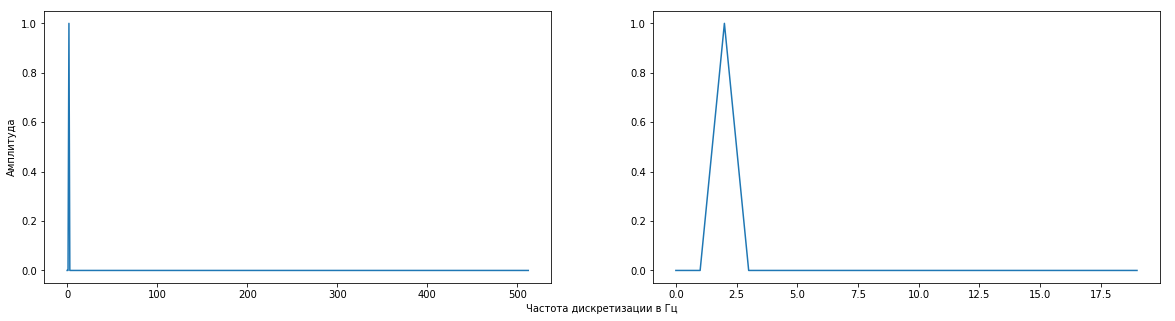

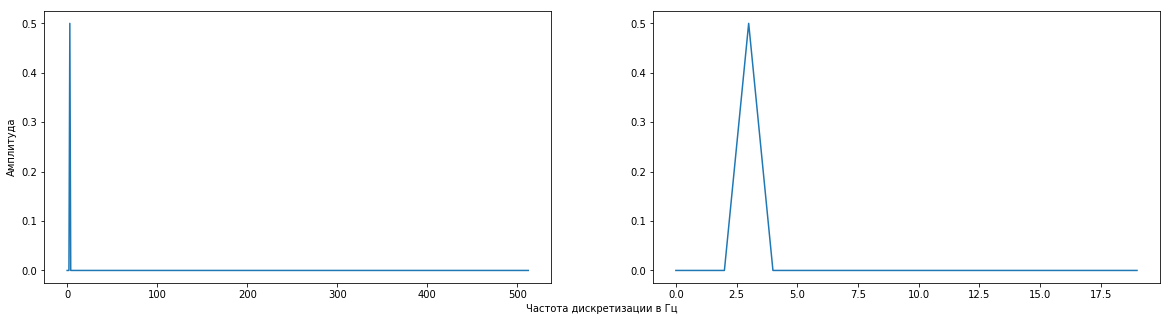

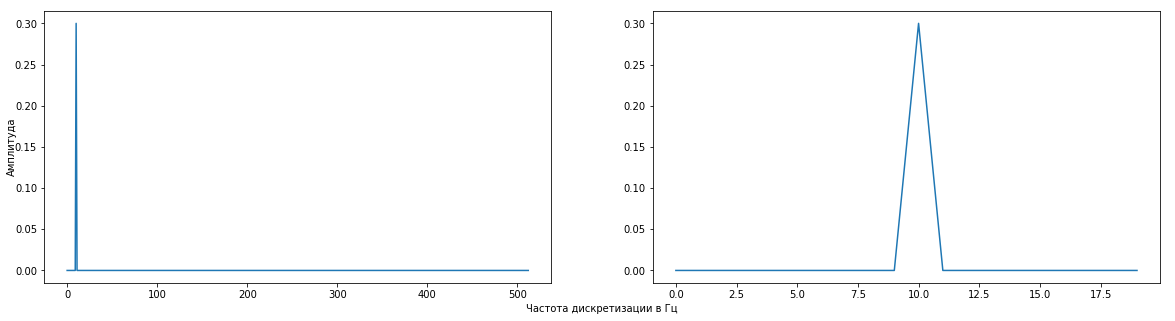

In [20]:
plot_example(X,Y, sample_size)

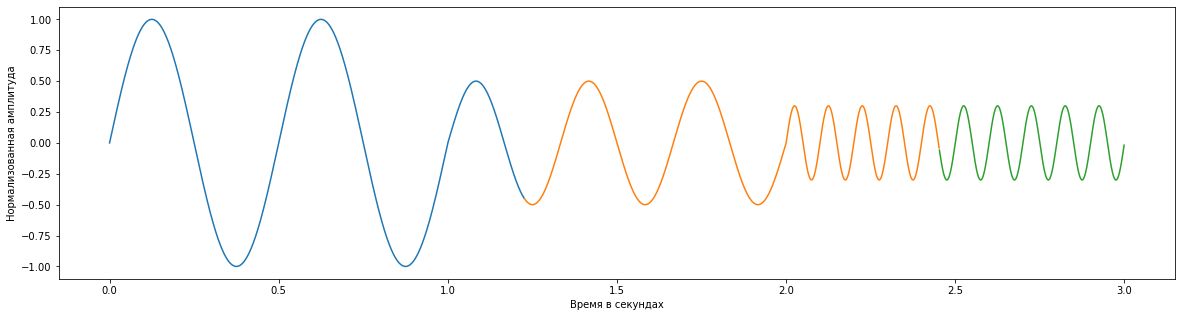

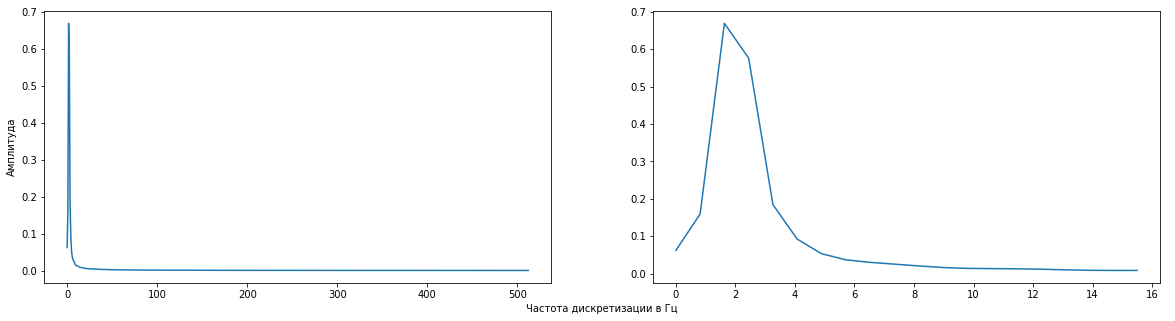

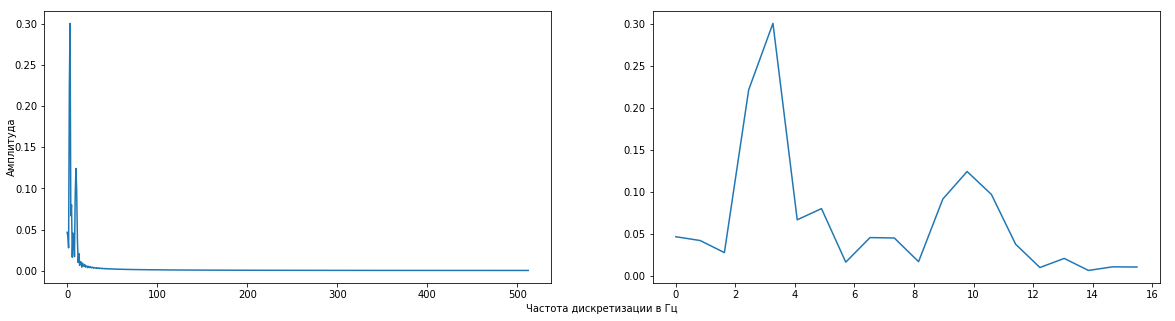

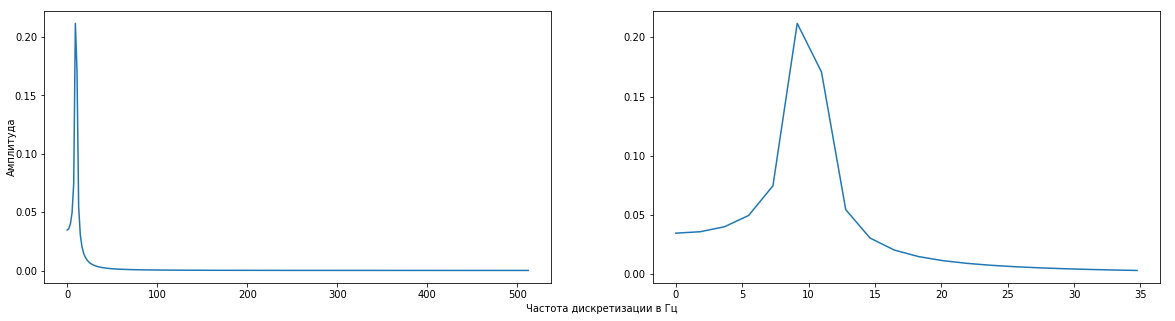

In [21]:
plot_example(X,Y, 1256)

Фильтры

In [22]:
func = lambda x: amplitude * np.sin(2 * np.pi * x *  1) \
                 + amplitude * np.sin(2 * np.pi * x * 3) \
                 + amplitude * np.sin(2 * np.pi * x * 5)

X = np.arange(0, 2, 1 / 1024)
Y = func(X)

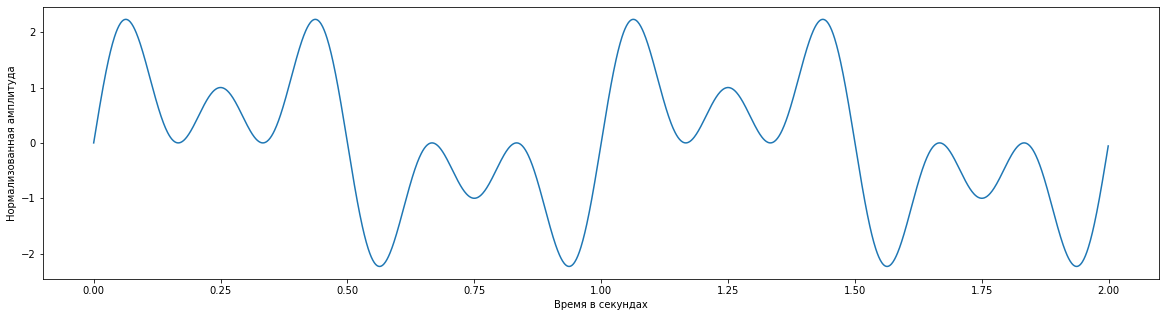

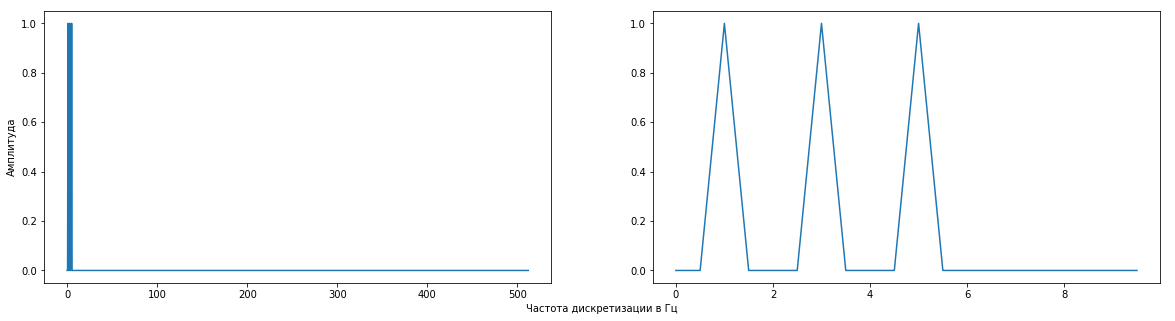

In [23]:
plot_example(X,Y, len(Y))

In [24]:
from scipy.signal import filtfilt, butter, freqz

In [25]:
def butter_lowpass(cutoff, discr, order=5):
    nyq = 0.5 * discr
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, discr, order=5):
    b, a = butter_lowpass(cutoff, discr, order=order)
    return filtfilt(b, a, data)

def plot_butter_filter(discr, cutoff, order, xlim):
    b, a = butter_lowpass(cutoff, discr, order)
    w, h = freqz(b, a, worN=8000)
    plt.plot(0.5 * discr * w / np.pi, np.abs(h), 'b')

    plt.plot(cutoff, 0.5 * np.sqrt(2), 'ko')
    plt.axvline(cutoff, color='k')

    plt.xlim(0, xlim)

    plt.grid()
    plt.xlabel("Lowpass Filter Frequency Response")
    plt.ylabel("Frequency [Hz]")


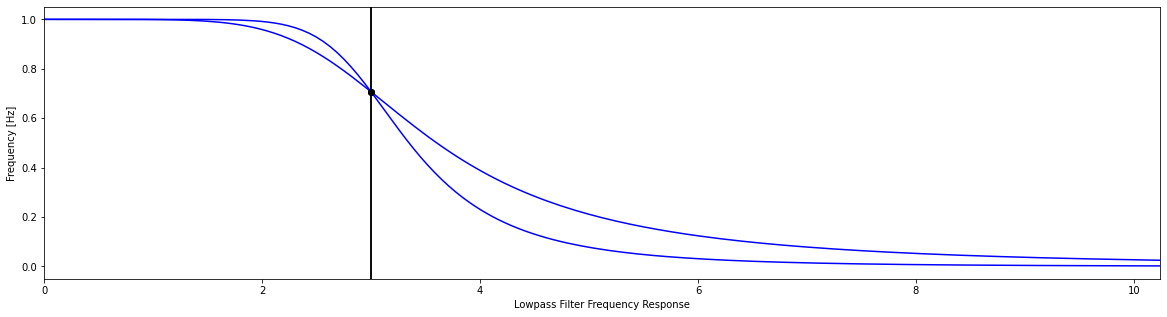

In [26]:
order = 3
discr = 1024
cutoff = 3

plot_butter_filter(discr, cutoff, order, 0.01 * discr)

order = 5
discr = 1024
cutoff = 3

plot_butter_filter(discr, cutoff, order, 0.01 * discr)

In [27]:
order = 3
discr = 1024
cutoff = 3

b, a = butter_lowpass(cutoff, discr, order)
y = butter_lowpass_filter(Y, cutoff, discr, order)

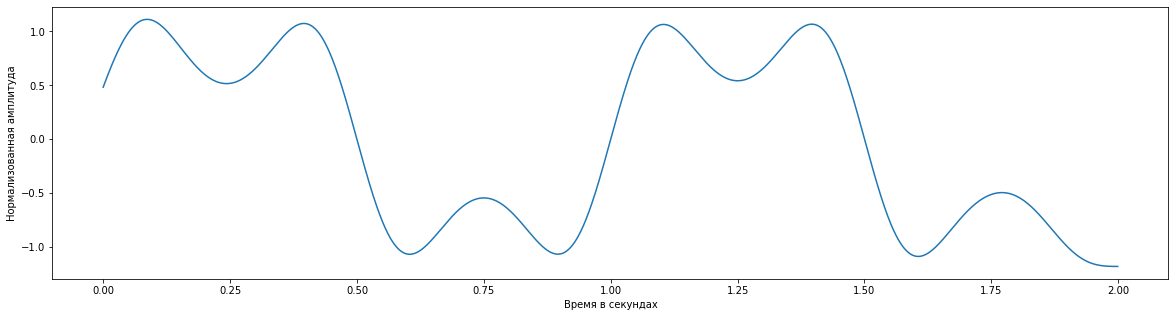

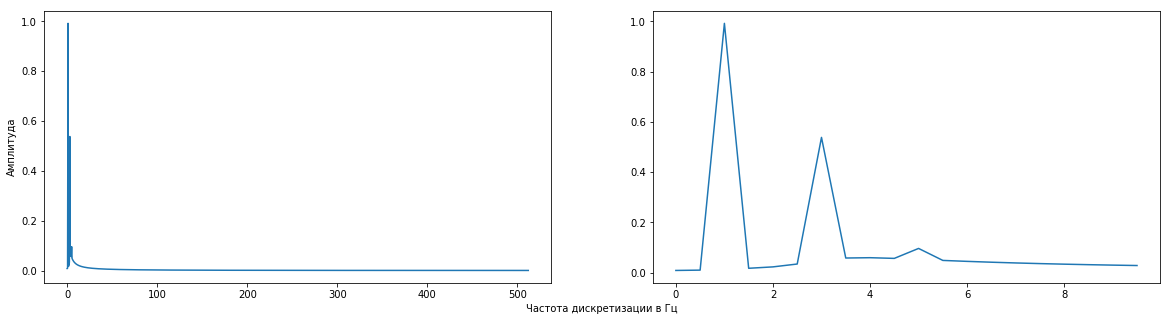

In [28]:
plot_example(X, y, len(y))

In [29]:
def downsampling(data, by: int = 4):
    return data[::by]

In [30]:
len(Y)

2048

In [31]:
downsampled = downsampling(Y)
len(downsampled)

512

In [32]:
discr = discr / 4

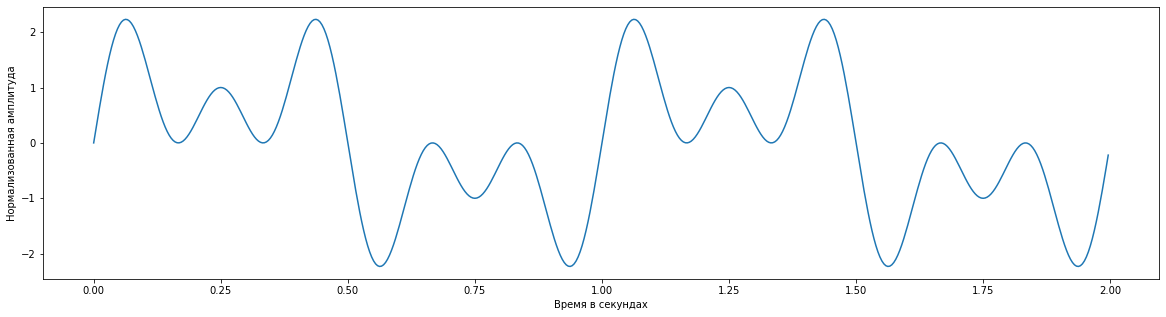

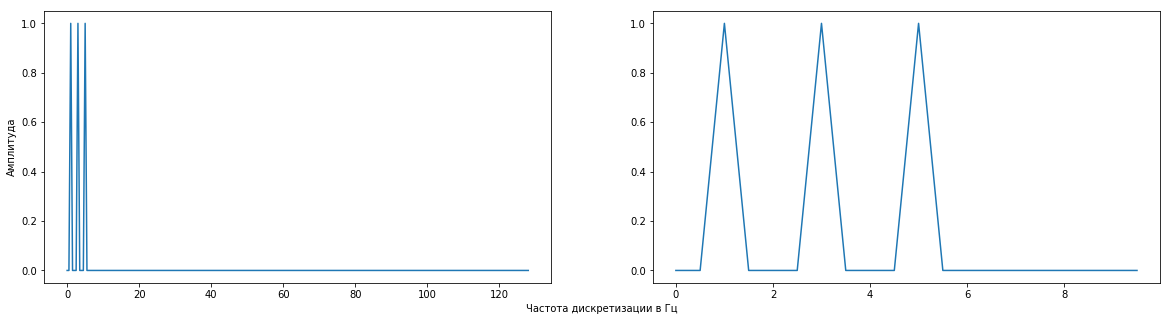

In [33]:
plot_example(downsampling(X), downsampled, len(downsampled))

In [34]:
# sound = AudioSegment.from_mp3("/home/araxal/harddrive/fma_small/155/155066.mp3")
# mono_track = stereo_to_mono(pydub_to_np(sound))
# mono_track.shape

In [35]:
# mono_track

In [36]:
from scipy.signal.windows import hamming

In [37]:
def get_windowed_fft_result(data, discr: int, window_rate: int, window_func = hamming):
    y_freq = []
    w = window_func(window_rate)
    for chunk in chunks(data, window_rate):
        if len(chunk) != window_rate:
            break

        windowed_chunk = chunk * w
        fft_res = np.abs(rfft(windowed_chunk))

        y_freq.append(fft_res)

    bins = rfftfreq(window_rate, d = 1 / discr)

    return bins, y_freq


In [38]:
bins, y_freq = get_windowed_fft_result(downsampled, discr, 128, hamming)
len(bins), len(y_freq), len(y_freq[0])

(65, 4, 65)

In [42]:
y_freq

[array([4.79868861e+01, 7.97604362e+00, 4.47934833e+00, 2.32810966e+01,
        4.60653716e+00, 2.47708683e-01, 1.34985794e-01, 1.78767003e-01,
        1.67579152e-01, 1.46736132e-01, 1.26494134e-01, 1.09043002e-01,
        9.45034009e-02, 8.24898491e-02, 7.25494723e-02, 6.42804321e-02,
        5.73542431e-02, 5.15101418e-02, 4.65430421e-02, 4.22917129e-02,
        3.86289133e-02, 3.54536338e-02, 3.26851387e-02, 3.02584320e-02,
        2.81208103e-02, 2.62292355e-02, 2.45483222e-02, 2.30487875e-02,
        2.17062478e-02, 2.05002801e-02, 1.94136833e-02, 1.84318945e-02,
        1.75425230e-02, 1.67349773e-02, 1.60001647e-02, 1.53302463e-02,
        1.47184388e-02, 1.41588506e-02, 1.36463478e-02, 1.31764423e-02,
        1.27451991e-02, 1.23491595e-02, 1.19852751e-02, 1.16508541e-02,
        1.13435143e-02, 1.10611443e-02, 1.08018700e-02, 1.05640258e-02,
        1.03461310e-02, 1.01468682e-02, 9.96506546e-03, 9.79968130e-03,
        9.64979096e-03, 9.51457512e-03, 9.39331001e-03, 9.285358

## AUDIO STARTS HERE

In [39]:
sound = AudioSegment.from_mp3("/home/araxal/harddrive/fma_small/155/155066.mp3")

In [40]:
mono_sound = stereo_to_mono(pydub_to_np(sound))

In [41]:
bin_groups = ((0, 10),(10, 20),(20, 40),(40, 80),(80, 160),(160, 511))